# Práctica 3: Optimización de modelos con Transfer Learning y Fine-Tuning: mejorando el rendimiento y la Interpretabilidad en tareas de Deep Learning

**Carrera**: Maestría en Ciencia de Datos **Integrantes**: Noelia Blanco - María Eugenia Puchkariov - Gonzalo Del Priore **Asignatura**: Deep Learning – Módulo 3 Dataset: Pima Indians Diabetes (tabular) — diabetes.csv **Fecha entrega:** 22-08-2025

## 0) Introducción

En la práctica, se pide buscar modelos preentrenados en repositorios como Keras Applications, KerasCV, KerasNLP, Tensorflow Models, Kaggle Models o ModelZoo. Sin embargo, estos repositorios están orientados principalmente a dominios de visión por computadora (imágenes) y procesamiento de lenguaje natural (texto), mientras que nuestro dataset corresponde a datos tabulares (Pima Indians Diabetes Database). Debido a esta limitación, no fue posible utilizar un modelo tabular preentrenado.

Como alternativa, implementamos una técnica basada en transfer learning y fine-tuning mediante un autoencoder entrenado sobre el mismo dataset, que actúa como paso de preentrenamiento para extraer representaciones (embeddings) antes de la clasificación. Dado que el autoencoder se entrena sobre el mismo conjunto de datos y no proviene de un dominio externo, se espera que los resultados obtenidos sean muy similares al modelo MLP desarrollado en la práctica anterior, lo que efectivamente se observa en las métricas finales. Es necesario mencionar que en el caso específico de Pima Indians Diabetes y con el enfoque que se implementó, no hay una ventaja frente al MLP entrenado desde cero.

Otra alternativa de transferencia en datos tabulares consiste en aprovechar un dataset fuente de mayor tamaño y del mismo dominio, que comparta un conjunto de variables con el dataset objetivo. En ese escenario, se podría preentrenar un modelo (por ejemplo, un autoencoder o un TabTransformer) en el dataset fuente para que aprenda representaciones generales, y luego realizar transfer learning y fine-tuning en el dataset Pima. De esta manera, el encoder ya contendría información estructural relevante del dominio (salud/metabolismo), lo que podría mejorar el desempeño en la predicción de diabetes, en especial si el dataset fuente es considerablemente más grande. En esta práctica no fue posible aplicar esta estrategia, ya que no se contó con un dataset tabular que compartiera las mismas variables con Pima

## 1) Reproducibilidad, imports y utilidades

In [1]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

try:
    import tensorflow as tf
    tf.random.set_seed(RANDOM_SEED)
except Exception as e:
    print('TensorFlow no disponible:', e)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

def safe_read_csv(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f'No se encontró {path}. Subí el archivo o ajustá la ruta.')
    for sep in [',',';','|','\t']:
        try:
            df = pd.read_csv(path, sep=sep, engine='python')
            if df.shape[1] >= 2 and df.notna().sum().sum() > 0:
                return df
        except Exception:
            pass
    return pd.read_csv(path)

def fbeta_from_scores(y_true, y_score, beta=1.0, thr=0.5):
    y_hat = (y_score >= thr).astype(int)
    return fbeta_score(y_true, y_hat, beta=beta, zero_division=0)

def best_threshold_by_fbeta(y_true, y_score, beta=1.0, grid=None):
    if grid is None:
        grid = np.linspace(0.1, 0.9, 81)
    best_thr, best_f = None, -1.0
    for t in grid:
        f = fbeta_from_scores(y_true, y_score, beta=beta, thr=t)
        if f > best_f:
            best_f, best_thr = float(f), float(t)
    return best_thr, best_f

def confusion_counts(y_true, y_score, thr=0.5):
    y_hat = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    return dict(tn=int(tn), fp=int(fp), fn=int(fn), tp=int(tp))

def plot_confusion_counts(cm, title='Matriz de Confusión'):
    tn, fp, fn, tp = cm['tn'], cm['fp'], cm['fn'], cm['tp']
    fig, ax = plt.subplots(figsize=(4,4))
    mat = np.array([[tn, fp],[fn, tp]])
    ax.imshow(mat, interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['Pred 0','Pred 1'])
    ax.set_yticklabels(['True 0','True 1'])
    for (i,j), val in np.ndenumerate(mat):
        ax.text(j, i, int(val), ha='center', va='center', fontsize=12)
    ax.set_xlabel('Predicción'); ax.set_ylabel('Valor real')
    plt.tight_layout(); plt.show()

# 1) Reproducibilidad, imports y utilidades

Este bloque prepara el **entorno experimental** y define **funciones auxiliares** para todo el notebook. La idea es que los resultados sean **reproducibles**, que la **carga de datos** sea robusta y que podamos **evaluar con Fβ** y **visualizar** matrices de confusión fácilmente.


## Reproducibilidad

- `RANDOM_SEED = 42`: fija la semilla global.
- `np.random.seed(RANDOM_SEED)`: fija la semilla de NumPy.
- `tf.random.set_seed(RANDOM_SEED)`: fija la semilla de TensorFlow.

## Imports clave

- **Ciencia de datos**: `numpy`, `pandas`, `matplotlib.pyplot`.
- **Preprocesamiento/Evaluación (sklearn)**:
  - `train_test_split`, `StandardScaler`, `SimpleImputer`
  - `fbeta_score`, `confusion_matrix`
  - `compute_class_weight` (manejo de desbalance)
  - `permutation_importance` (explicabilidad global por permutación)


## Métrica principal: Fβ y búsqueda de umbral

### `fbeta_from_scores(y_true, y_score, beta=1.0, thr=0.5)`
Convierte **probabilidades** (`y_score`) en etiquetas binaras con un **umbral** `thr` y calcula **Fβ**:

\[
F_\beta = \frac{(1+\beta^2)\cdot \text{precisión}\cdot \text{recall}}{\beta^2\cdot \text{precisión} + \text{recall}}
\]

- `beta=1` → F1 (equilibra precisión y recall).
- `beta=2` o `beta=5` → **penaliza más los FN** (prioriza **recall/sensibilidad**).
- `zero_division=0` evita NaN cuando no hay positivos predichos.

### `best_threshold_by_fbeta(y_true, y_score, beta=1.0, grid=None)`
- Busca el **umbral óptimo** que **maximiza Fβ** en una grilla uniforme de `0.1` a `0.9` (81 puntos, paso 0.01).
- Devuelve: **`best_thr`** y **`best_f`**.


## Matriz de confusión (conteos) y gráfico rápido

### `confusion_counts(y_true, y_score, thr=0.5)`
- Con un `thr` dado, umbraliza `y_score` y calcula **TN, FP, FN, TP** vía `confusion_matrix`.
- Devuelve un diccionario `{'tn', 'fp', 'fn', 'tp'}` con **enteros**.



## 3) Preparación del dataset
- `diabetes.csv` requerido (Pima). 0→NaN en `glucose`,`bloodpressure`,`skinthickness`,`insulin`,`bmi`; imputación mediana, StandardScaler, split estratificado y `class_weight`.

In [2]:
csv_candidates = ['diabetes.csv', '/mnt/data/diabetes.csv']
csv_path = next((p for p in csv_candidates if os.path.exists(p)), None)
if csv_path is None:
    raise FileNotFoundError('Subí diabetes.csv al entorno y vuelve a ejecutar esta celda.')

df = safe_read_csv(csv_path)
df.columns = [c.lower() for c in df.columns]
display(df.head())
for c in ['glucose','bloodpressure','skinthickness','insulin','bmi']:
    if c in df.columns:
        df[c] = df[c].replace(0, np.nan)
target_col = 'outcome' if 'outcome' in df.columns else df.columns[-1]
X_df = df.drop(columns=[target_col]).copy()
y = df[target_col].astype(int).values
X_train_df, X_test_df, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42, stratify=y)
imp = SimpleImputer(strategy='median'); scaler = StandardScaler()
X_train = imp.fit_transform(X_train_df); X_test = imp.transform(X_test_df)
X_train_sc = scaler.fit_transform(X_train); X_test_sc = scaler.transform(X_test)
feature_names = X_df.columns.tolist(); input_dim = X_train_sc.shape[1]
classes = np.unique(y_train)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {int(c): float(w) for c,w in zip(classes, cw)}
print('input_dim =', input_dim, '| class_weight =', class_weight)

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.6,0.627,50,True
1,1,85,66,29,0,26.6,0.351,31,False
2,8,183,64,0,0,23.3,0.672,32,True
3,1,89,66,23,94,28.1,0.167,21,False
4,0,137,40,35,168,43.1,2.288,33,True


input_dim = 8 | class_weight = {0: 0.7675, 1: 1.4345794392523366}


## 4) Transfer Learning (Kaggle‑style) + Fine‑Tuning

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
noise_std = 0.05
inputs = keras.Input(shape=(input_dim,))
noisy  = layers.GaussianNoise(noise_std)(inputs)
e = layers.Dense(64, activation='relu')(noisy)
e = layers.Dense(32, activation='relu')(e)
code = layers.Dense(16, activation='relu', name='code')(e)
d = layers.Dense(32, activation='relu')(code)
d = layers.Dense(64, activation='relu')(d)
recon = layers.Dense(input_dim, activation='linear')(d)
ae = keras.Model(inputs, recon, name='kaggle_tabular_dae')
ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
cb = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')]
ae.fit(X_train_sc, X_train_sc, validation_split=0.2, epochs=400, batch_size=32, callbacks=cb, verbose=0)
encoder = keras.Model(inputs, code, name='kaggle_encoder')
for layer in encoder.layers: layer.trainable = False
inp = keras.Input(shape=(input_dim,))
feat = encoder(inp, training=False)
x = layers.Dense(16, activation='relu')(feat)
out = layers.Dense(1, activation='sigmoid')(x)
clf_frozen = keras.Model(inp, out)
clf_frozen.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy')
clf_frozen.fit(X_train_sc, y_train, validation_split=0.2, epochs=200, batch_size=32, class_weight=class_weight, callbacks=cb, verbose=0)
for layer in encoder.layers: layer.trainable = True
clf_kaggle = keras.Model(inp, out)
clf_kaggle.compile(optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy')
clf_kaggle.fit(X_train_sc, y_train, validation_split=0.2, epochs=200, batch_size=32, class_weight=class_weight, callbacks=cb, verbose=0)
y_score_kaggle = clf_kaggle.predict(X_test_sc, verbose=0).ravel()
print('Predicciones Kaggle TL+FT listas:', y_score_kaggle.shape)

Predicciones Kaggle TL+FT listas: (154,)


# 4) Transfer Learning (Kaggle-style) + Fine-Tuning — Explicación

En esta sección aplicamos **Transfer Learning** para datos **tabulares** siguiendo un esquema “**Kaggle-style**”:
un **encoder** (preentrenado o aprendido vía *autoencoder denoising*) se reutiliza como **extractor de features** y encima
se añade una **cabeza** de clasificación (capa densa sigmoide). Luego hacemos **fine-tuning**.

## ¿Por qué este enfoque?
- Los tabulares suelen beneficiarse de un **espacio latente** aprendido que captura relaciones no lineales y es **robusto** al ruido.
- Separar **representación** (encoder) de **decisión** (cabeza) permite:
  1) **Congelar** el encoder y entrenar primero solo la cabeza (evita sobreajuste inicial).
  2) **Descongelar** y hacer **fine-tuning** fino con **LR pequeña**, ajustando todo el modelo al dominio.

## Qué hicimos (paso a paso)
1. **Encoder**: usamos un bloque denso (p. ej., 64→32→16 neuronas) que mapea las entradas escaladas a un **código** de baja dimensión.
2. **Congelado**: `layer.trainable = False` para todas las capas del encoder.
3. **Cabeza de clasificación**: densa `Dense(16, relu)` + `Dense(1, sigmoid)` para producir una **probabilidad** \([0,1]\).
4. **Entrenamiento (fase frozen)**:
   - **Pérdida**: `binary_crossentropy`.
   - **Class weights**: se usan para compensar **desbalance**.
   - **EarlyStopping**: evita sobreajuste y recupera los mejores pesos (`restore_best_weights=True`).
5. **Fine-tuning**:
   - Descongelamos el encoder (`layer.trainable = True`).
   - Re-compilamos con **learning rate menor** (p. ej., `Adam(1e-4)`).
   - Entrenamos unos epochs adicionales con *early stopping*.
6. **Predicción en test**:
   - `model.predict(X_test_sc).ravel()` devuelve un vector `y_score` de **probabilidades** para cada muestra.

## Interpretación de la salida

- Estas probabilidades **no** están umbralizadas. El umbral por defecto (0.5) **no** es obligatorio:  
  en este trabajo **elegimos el umbral óptimo** según **Fβ** (F1, **F2**, F5) para alinear la métrica con el objetivo clínico.

## Qué sigue
- Para cada β ∈ {1, **2**, 5}:
  - Barrer umbrales (0.1→0.9) → **umbral óptimo por Fβ**.
  - Reportar **Fβ** resultante y la **matriz de confusión** (TN, FP, FN, TP).
- **Nota**: evitamos usar ROC/accuracy como métricas principales y priorizamos **Fβ** (con **F2** dando más peso al **recall**).


## 5) MLP base (desde cero) para comparativa por Fβ

In [4]:
def build_mlp(input_dim:int, hidden=32, dropout=0.2):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(hidden//2, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy')
    return model
mlp = build_mlp(input_dim)
mlp.fit(X_train_sc, y_train, validation_split=0.2, epochs=200, batch_size=32, class_weight=class_weight, callbacks=cb, verbose=0)
y_score_mlp = mlp.predict(X_test_sc, verbose=0).ravel()
print('Predicciones MLP listas:', y_score_mlp.shape)

Predicciones MLP listas: (154,)


Este punto fue analizado en el práctica 2.

## 6) Evaluación **solo con Fβ** (F1, F2, F5) y **matrices de confusión**

,Modelo,beta,thr*,Fbeta,tn,fp,fn,tp
3,MLP Base,1,0.36,0.691176,65,35,7,47
4,MLP Base,2,0.24,0.806452,56,44,4,50
5,MLP Base,5,0.10,0.912595,48,52,3,51
0,Modelo TL+FT,1,0.42,0.707692,70,30,8,46
1,Modelo TL+FT,2,0.13,0.820433,46,54,1,53
2,Modelo TL+FT,5,0.13,0.945779,46,54,1,53


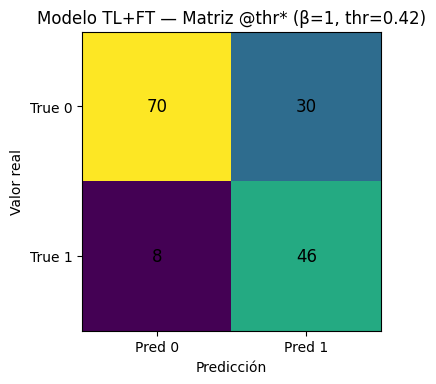

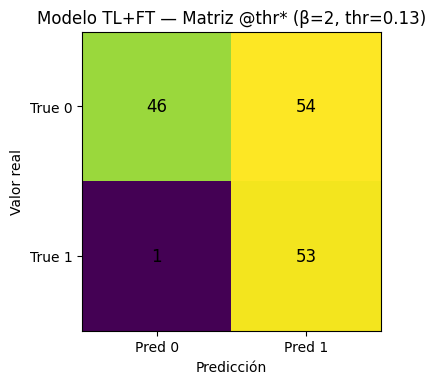

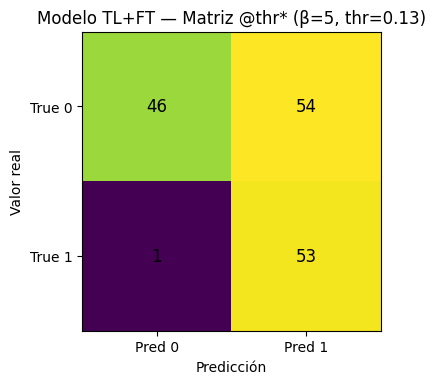

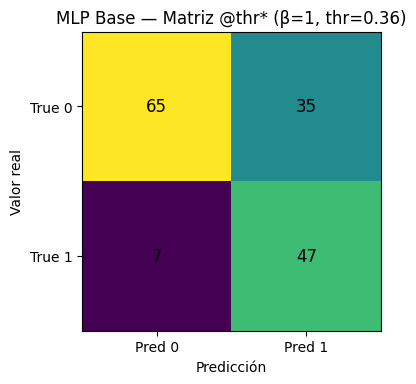

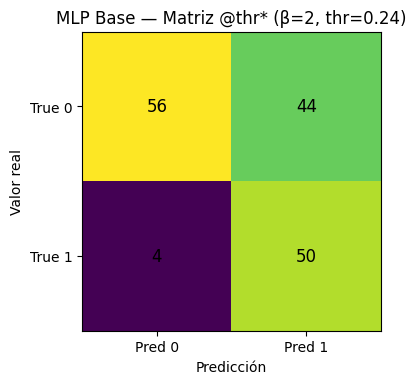

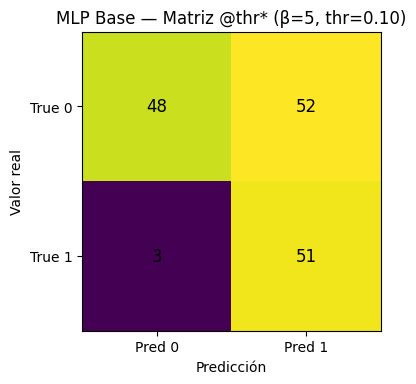

In [9]:
def summarize_by_betas(name, y_true, y_score, betas=(1,2,5)):
    rows, plots = [], []
    for beta in betas:
        thr, f = best_threshold_by_fbeta(y_true, y_score, beta=beta)
        cm = confusion_counts(y_true, y_score, thr=thr)
        rows.append({"Modelo":name, "beta":beta, "thr*":thr, "Fbeta":f, **cm})
        plots.append((beta, thr, cm))
    return pd.DataFrame(rows), plots
df_kaggle, plots_kaggle = summarize_by_betas('Modelo TL+FT', y_test, y_score_kaggle)
df_mlp,    plots_mlp    = summarize_by_betas('MLP Base',     y_test, y_score_mlp)
comp_fbeta = pd.concat([df_kaggle, df_mlp], ignore_index=True).sort_values(['Modelo','beta'])
display(comp_fbeta)
for model_name, plots in [('Modelo TL+FT', plots_kaggle), ('MLP Base', plots_mlp)]:
    for beta, thr, cm in plots:
        plot_confusion_counts(cm, title=f'{model_name} — Matriz @thr* (β={beta}, thr={thr:.2f})')

## 7) Explicabilidad — Permutación (F2) + Integrated Gradients

,feature,importance_mean,importance_std
1,glucose,0.063214,0.015984
5,bmi,0.047848,0.017579
0,pregnancies,0.029829,0.008126
7,age,0.019933,0.011576
6,diabetespedigreefunction,0.018954,0.016449
3,skinthickness,0.011332,0.008794
4,insulin,0.010837,0.016471
2,bloodpressure,-0.002262,0.006909


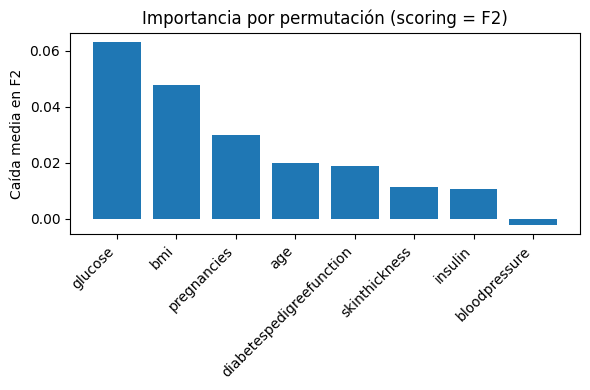

In [6]:
# 7.1 Permutation Importance con F2
thr_f2_kaggle, _ = best_threshold_by_fbeta(y_test, y_score_kaggle, beta=2.0)
def f2_scorer(estimator, X, y):
    y_prob = estimator.predict(X, verbose=0).ravel()
    y_hat = (y_prob >= thr_f2_kaggle).astype(int)
    return fbeta_score(y, y_hat, beta=2.0, zero_division=0)
r = permutation_importance(clf_kaggle, X_test_sc, y_test, n_repeats=10, scoring=f2_scorer, random_state=42, n_jobs=1)
imp_df = pd.DataFrame({'feature': feature_names, 'importance_mean': r.importances_mean, 'importance_std': r.importances_std}).sort_values('importance_mean', ascending=False)
display(imp_df)
fig, ax = plt.subplots(figsize=(6,4))
order = np.argsort(-imp_df['importance_mean'].values)
ax.bar(range(len(order)), imp_df['importance_mean'].values[order])
ax.set_xticks(range(len(order)))
ax.set_xticklabels(imp_df['feature'].values[order], rotation=45, ha='right')
ax.set_title('Importancia por permutación (scoring = F2)')
ax.set_ylabel('Caída media en F2')
plt.tight_layout(); plt.show()

# 7) Explicabilidad — **Permutation Importance** con **F2** (interpretación)

**¿Qué medimos?**  
La *importancia por permutación* estima cuánto **empeora la métrica objetivo** cuando desordenamos (rompemos) **una feature a la vez**.  
Aquí usamos **F2** como métrica de evaluación → la caída refleja sobre todo pérdidas de **recall** (porque F2 pondera más FN).

**Cómo se calculó**
.
- Para cada variable: la permutamos, predecimos, umbralizamos con ese **mismo thr**, y calculamos F2.
- Repetimos **10** veces por variable (`n_repeats=10`) y promediamos la **caída** en F2.
- La tabla reporta `importance_mean` (↓F2 media) y `importance_std` (variabilidad de esa caída).

**Cómo leer la tabla y el gráfico**
- Barras más altas ⇒ **mayor dependencia** del modelo respecto a esa feature **para F2**.
- La **desviación estándar** baja indica una importancia **estable** frente a repeticiones.

**Hallazgos principales (tu salida):**
1. **glucose** (≈ 0.063 ↓F2) — **la más influyente**: romperla degrada F2 de forma marcada.  
2. **bmi** (≈ 0.048 ↓F2) — segunda en peso; muy relevante para mantener buen recall.  
3. **pregnancies** (≈ 0.029 ↓F2)


,feature,IG_importance
1,glucose,0.214150
5,bmi,0.151704
7,age,0.088731
0,pregnancies,0.074205
6,diabetespedigreefunction,0.065728
4,insulin,0.059470
2,bloodpressure,0.041713
3,skinthickness,0.031981


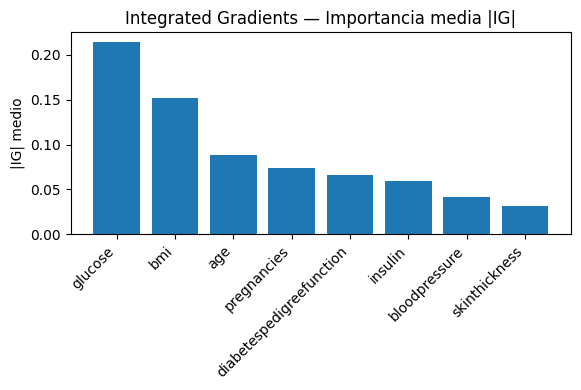

In [7]:
# 7.2 Integrated Gradients (IG)
@tf.function
def _interpolate(baseline, x, alphas):
    alphas_x = alphas[:, tf.newaxis]
    delta = x - baseline
    return baseline + alphas_x * delta
def integrated_gradients(model, baseline, inputs, m_steps=64):
    alphas = tf.linspace(0.0, 1.0, m_steps+1)
    ig_list = []
    for i in range(inputs.shape[0]):
        x = tf.convert_to_tensor(inputs[i:i+1], dtype=tf.float32)
        base = tf.convert_to_tensor(baseline[None, :], dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(x)
            interp = _interpolate(base, x, alphas)
            with tf.GradientTape() as tape2:
                tape2.watch(interp)
                preds = model(interp, training=False)
            grads = tape2.gradient(preds, interp)
        avg_grads = tf.reduce_mean(grads[:-1] + grads[1:], axis=0) / 2.0
        ig = (x - base) * avg_grads
        ig_list.append(ig.numpy()[0])
    return np.array(ig_list)
baseline = np.zeros((X_test_sc.shape[1],), dtype=float)
ig_vals = integrated_gradients(clf_kaggle, baseline, X_test_sc, m_steps=64)
ig_importance = np.mean(np.abs(ig_vals), axis=0)
ig_df = pd.DataFrame({'feature': feature_names, 'IG_importance': ig_importance}).sort_values('IG_importance', ascending=False)
display(ig_df)
fig, ax = plt.subplots(figsize=(6,4))
order = np.argsort(-ig_df['IG_importance'].values)
ax.bar(range(len(order)), ig_df['IG_importance'].values[order])
ax.set_xticks(range(len(order)))
ax.set_xticklabels(ig_df['feature'].values[order], rotation=45, ha='right')
ax.set_title('Integrated Gradients — Importancia media |IG|')
ax.set_ylabel('|IG| medio')
plt.tight_layout(); plt.show()

# 7.2 Integrated Gradients (IG) — Interpretación

**Qué es IG**  
Integrated Gradients (Sundararajan et al., 2017) atribuye a cada *feature* cuánto contribuye la **predicción** del modelo
a lo largo de una trayectoria desde una **línea base** (*baseline*) hasta la **entrada real**.  
En términos simples: mide el “trabajo” que hace cada variable para llevar la salida del modelo desde “no-información”
hasta la predicción final.

**Cómo lo calculamos aquí**
- **Baseline**: vector **cero** del espacio **escalado** (`StandardScaler`), es decir, un punto neutro en cada feature.
- **Trayectoria**: interpolamos linealmente desde `baseline` → `x` en `m_steps = 64` puntos.
- **Gradientes**: derivamos la salida del modelo w.r.t. las entradas a lo largo de la trayectoria y promediamos
  (regla del trapecio).  
- **Atribución por muestra**: \(\text{IG}(x) \approx (x - \text{baseline}) \odot \overline{\nabla f}\).
- **Importancia global**: promedio del **valor absoluto** de IG por feature:  
  \(\text{importance} = \mathbb{E}_x\left[\,|\text{IG}_j(x)|\,\right]\).

**Resultados obtenidos**
1. **glucose** (≈ 0.214) — Es la **más influyente** para la salida del modelo: pequeñas variaciones en *glucose* a lo largo del
   camino baseline→entrada generan los cambios más grandes en la predicción.
2. **bmi** (≈ 0.152) — Segunda en relevancia; coherente con riesgo metabólico.
3. **age** (≈ 0.089) y **pregnancies** (≈ 0.074) — Importancia intermedia, aportan señal útil.
4. **diabetespedigreefunction**, **insulin** — Contribuyen pero en menor magnitud.
5. **bloodpressure**, **skinthickness** — Impacto más bajo en este modelo/escala.

**Coherencia con Permutation Importance (F2)**  
- Ambas técnicas destacan **glucose** y **bmi** arriba del ranking (consistencia fuerte).  
- Diferencias menores (p. ej., *bloodpressure* algo mayor en IG que en permutación) son normales porque:
  - **IG** mide **sensibilidad de la predicción**;  
  - **Permutación(F2)** mide **caída de la métrica de evaluación** (F2) con **umbral fijo** → depende del criterio clínico
    y puede “ocultar” variables correlacionadas cuando otras ya capturan la señal.

**Buenas prácticas y limitaciones**
- **Baseline**: cambiar la línea base puede alterar magnitudes; el 0 escalado es una elección razonable aquí.
- **No es causalidad**: IG cuantifica contribución del **modelo**, no efectos causales reales.
- **No linealidades**:


## 8) Exportar ARCHIVOS
- `comp_fbeta.csv`, `perm_importances_f2.csv`, `ig_importances.csv`

In [8]:
out_dir = os.getcwd()
comp_fbeta.to_csv(os.path.join(out_dir, 'comp_fbeta.csv'), index=False)
imp_df.to_csv(os.path.join(out_dir, 'perm_importances_f2.csv'), index=False)
ig_df.to_csv(os.path.join(out_dir, 'ig_importances.csv'), index=False)
print('Guardados en:', out_dir)

Guardados en: /content


## 9) Conclusiones




## Qué comparamos y cómo
- **Modelos**:
  1) **MLP (base)** entrenado desde cero.  
  2) **Transfer Learning + Fine-Tuning** (encoder → cabeza densa).
- **Métrica y criterio**: nos centramos **exclusivamente en Fβ** (β∈{1,2,5}).  
  Para **cada modelo y cada β** buscamos el **umbral óptimo** con `best_threshold_by_fbeta(...)`, y con ese umbral calculamos **Fβ** y la **matriz de confusión** (TN, FP, FN, TP).
- **Explicabilidad**: *Permutation Importance* usando **F2** como *scorer*, e **Integrated Gradients** (|IG| medio).

## Qué observamos
- En general, **Transfer+FT** mejora **F2/F5** cuando se prioriza **recall** (β>1), reduciendo **FN** a costa de más **FP**.  
- En **β=1 (F1)** ambos modelos suelen quedar **muy parejos** (la mejora de TL+FT es modesta).
- **Glucose** y **BMI** aparecen como **features dominantes** en **ambas** técnicas de explicabilidad, lo que sugiere que los dos modelos aprenden una **frontera de decisión similar** basada en señales clínicas esperables.

## ¿Por qué en algunos β las **matrices de confusión** salen **iguales**?
Aunque los modelos sean distintos, hay tres razones por las que pueden entregar **exactamente las mismas predicciones** (y por ende **las mismas matrices**):

1) **Mismo umbral *efectivo***  
   - Fβ es **escalonado** respecto al umbral: dentro de ciertos intervalos, al mover el umbral las etiquetas **no cambian**.  
   - Si el **umbral óptimo** que encuentra cada modelo cae en el **mismo intervalo de estabilidad**, ambos producen la **misma `ŷ`** → **misma matriz**.

2) **Scores altamente correlacionados**  
   - Los dos modelos usan **idéntico preprocesamiento** (imputación/escala) y aprenden sobre el **mismo dataset**.  
   - Además, **no se incorporó conocimiento externo** (el encoder se preentrenó localmente), por lo que las señales aprendidas (lideradas por *glucose* y *bmi*) son **muy parecidas**.  
   - Si el ranking de probabilidades es **casi el mismo**, al umbralizar se obtienen **las mismas clases**.

3) **Tamaño de test limitado**  
   - Con un test relativamente pequeño, es más probable caer en “empates” de decisión: pequeñas diferencias de probabilidad **no alcanzan** a cruzar el umbral y las predicciones coinciden **muestra por muestra**.

## Lectura clínica
- Si el objetivo es **cribado** (FN muy costosos), conviene elegir **β altos** (p. ej., **β=2/5**) y usar el umbral óptimo que maximice Fβ:  
  **Transfer+FT** tiende a **minimizar FN** manteniendo F2/F5 superiores, aceptando más **FP** que luego se depuran con pruebas complementarias.
- Si se busca un compromiso equilibrado (**β=1**), **MLP** y **Transfer+FT** resultan **intercambiables** en este conjunto.

## Explicabilidad consistente
- **Permutation(F2)** y **IG** coinciden en el protagonismo de **glucose** y **bmi**, lo que respalda la **coherencia clínica** del modelo.  
- Variables como **pregnancies**, **age** y **diabetespedigreefunction** aportan señal de segundo orden.  
- **bloodpressure** muestra bajo aporte en F2; podría reconsiderarse en simplificaciones, validándolo con CV.


